In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import time
import pickle

In [2]:
%pylab inline
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'

center_ra = 19.3*galsim.hours     # The RA, Dec of the center of the image on the sky
center_dec = -33.1*galsim.degrees

pix_wfirst = 0.11
pix_LSST = 0.2
pix_HST = 0.06
pix_Euclid = 0.1
pix_HSC = 0.167

#Sigma of the psf profile in arcseconds.
sigma_wfirst = 1.69*0.11 #https://arxiv.org/pdf/1702.01747.pdf Z-band
sigma_LSST = 0.7 #https://www.lsst.org/about/camera/features
sigma_Euclid = 0.16 #https://sci.esa.int/documents/33859/36320/1567253682555-Euclid_presentation_Paris_1Dec2009.pdf
sigma_HST = 0.074 #Source https://hst-docs.stsci.edu/display/WFC3IHB/6.6+UVIS+Optical+Performance#id-6.6UVISOpticalPerformance-6.6.1 800nm
sigma_HSC = 0.62 #https://hsc-release.mtk.nao.ac.jp/doc/ deep+udeep

EUCLID = {'name': 'EUCLID', 'pixel': pix_Euclid ,'psf': sigma_Euclid}
HST = {'name': 'HST', 'pixel': pix_HST,'psf': sigma_HST}
HSC = {'name': 'HSC', 'pixel': pix_HSC,'psf': sigma_HSC}
WFIRST = {'name': 'WFIRST', 'pixel': pix_wfirst,'psf': sigma_wfirst}
LSST = {'name': 'LSST', 'pixel': pix_LSST,'psf': sigma_LSST}

matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')
matplotlib.rc('xtick', labelsize=20) 

Populating the interactive namespace from numpy and matplotlib


In [3]:
import galsim
# First step is to find an HST PSF that will work for all images,
# we are taking a random sample of 1000 psfs, take the largest one,
# and dilate it a little bit with GalSim

cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')
psfs = []
psfs_fwhm = []
npsf = 51

ims_r = [ ]

def mk_wcs(theta, pix, center, shape):
    '''Creates wcs for an image'''
    #Affine transformation
    dudx = numpy.cos(theta) * pix
    if theta == 0:
        dudy = 0
        dvdx = 0
    else:
        dudy = -numpy.sin(theta) * pix
        dvdx = numpy.sin(theta) * pix
    dvdy = numpy.cos(theta) * pix
    
    affine = galsim.AffineTransform(dudx, dudy, dvdx, dvdy, origin=center)
    #Image center
    sky_center = galsim.CelestialCoord(ra=center_ra, dec=center_dec)
    #Creating WCS
    w = WCS.WCS(naxis=2)
    galfit_wcs = galsim.TanWCS(affine, sky_center, units=galsim.arcsec)

    w.wcs.ctype = ["RA---AIR", "DEC--AIR"]
    w.wcs.crpix = galfit_wcs.crpix

    w.wcs.pc = galfit_wcs.cd
    w.wcs.crval = [galfit_wcs.center._ra._rad, galfit_wcs.center._dec._rad]
    w.array_shape = shape
    return w
    

def mk_sim(k, hr_dir, lr_dir, shape_hr, shape_lr):
    '''creates low and high resolution images of a galaxy profile with different psfs
    '''
    pix_hr = hr_dir['pixel']
    pix_lr = lr_dir['pixel']
    sigma_hr = hr_dir['psf']
    sigma_lr = lr_dir['psf']
    #Rotation angle
    theta = random.randn(1)*np.pi*0
    angle = galsim.Angle(theta,galsim.radians)
    
    #Image frames
    im_hr = galsim.Image(shape_hr[0], shape_hr[1], scale=pix_hr)
    im_lr = galsim.Image(shape_lr[0], shape_lr[1], scale=pix_lr)
    
    #Galaxy profile
    gal = cat.makeGalaxy(k, gal_type = 'real', noise_pad_size=shape_lr[0] * pix_lr*0)#cat.makeGalaxy(gal_type='real',noise_pad_size=0*shape_hr[0] * pix_lr)
    #psf hr
    psf = gal.original_psf
    #Set PSFs
    x,y, = np.arange(npsf), np.arange(npsf)
    
    psf_hr_int = galsim.Moffat(2, sigma_hr)#.dilate(sigma_hr/sigma_HST).withFlux(1.)
    psf_lr_int = galsim.Moffat(2, sigma_lr)#.dilate(sigma_lr/sigma_HST).withFlux(1.)
    
    
    #psf_hr_fft = np.fft.fft2(np.pad(psf_hr, 10))
    #psf_hr = np.fft.ifft2(psf_hr_fft.real).real[10:-10, 10:-10]
    #psf_hr_int = galsim.InterpolatedImage(galsim.Image(psf_hr), scale = pix_hr)
    psf_hr = psf_hr_int.drawImage(nx=npsf,ny=npsf, method = 'real_space',
                                  use_true_center = True, scale = pix_hr).array
    psf_lr = psf_lr_int.drawImage(nx=npsf,ny=npsf, method = 'real_space',
                                  use_true_center = True, scale = pix_lr).array
    
    #psf_lr_fft = np.fft.fft2(np.pad(psf_lr, 10))
    #psf_lr = np.fft.ifft2(psf_lr_fft.real).real[10:-10, 10:-10]
    #psf_lr_int = galsim.InterpolatedImage(galsim.Image(psf_lr), scale = pix_lr)

    #We would normally rotate the low resolution psf, but I'm a cheap bastard
    #psf_hr = galsim.InterpolatedImage(galsim.Image(psf_hr0), scale = pix_hr)
    #psf_lr = galsim.InterpolatedImage(galsim.Image(psf_lr0), scale = pix_lr)
    #Convolve by PSF, rotate and resample
    im_hr = galsim.Convolve(gal, psf_hr_int).drawImage(nx=shape_hr[0],ny=shape_hr[1], 
                                                       use_true_center = True, method = 'no_pixel',
                                                   scale = pix_hr, dtype = float64)
    im_lr = galsim.Convolve(gal.rotate(angle), psf_lr_int).drawImage(nx=shape_lr[0],ny=shape_lr[1], 
                                                                     use_true_center = True, method = 'no_pixel',
                                                                 scale = pix_lr, dtype = float64)
    
    #Make WCSs
    im_hr.wcs = mk_wcs(0, pix_hr, galsim.PositionD(im_hr.true_center), shape_hr)
    im_lr.wcs = mk_wcs(0, pix_lr, galsim.PositionD(im_lr.true_center), shape_lr)
   
    return im_hr, im_lr, psf_hr[None,:,:], psf_lr[None, :,:], theta

In [4]:
channel_hr = ['hr']
channel_lr = ['lr']

channels = channel_lr+channel_hr

def interp_scarlet(data_hr, data_lr, psf_hr, psf_lr):
    '''apply resampling from scarlet
    '''
    #Extract data
    im_hr = data_hr.array[None, :, :]
    im_lr = data_lr.array[None, :, :]

    _,n1,n2 = im_hr.shape
    shape = (len(channels), n1,n2)
    # Initialize the frame using the PSFs and WCSs
    frame = scarlet.Frame(shape, wcs=data_hr.wcs, psfs=psf_hr, channels=channels)
    
    # define two observation objects and match to frame  
    obs_hr = scarlet.Observation(im_hr, wcs=data_hr.wcs, psfs=psf_hr, channels=channel_hr)
    obs_lr = scarlet.Observation(im_lr, wcs=data_lr.wcs, psfs=psf_lr, channels=channel_lr)

    # Keep the order of the observations consistent with the `channels` parameter
    # This implementation is a bit of a hack and will be refined in the future
    obs = [obs_lr, obs_hr]
    
    frame = scarlet.Frame.from_observations(obs, obs_id = 1, coverage = 'union')
    obs_lr, obs_hr = obs
    return obs_lr
    
def interp_galsim(data_hr, data_lr, diff_psf, angle, h_hr, h_lr):
    '''Apply resampling from galsim
    '''
    #Extract data
    im_hr = data_hr.array[None, :, :]
    im_lr = data_lr.array[None, :, :]
    _,n_hr,n_hr = im_hr.shape
    _,n_lr,n_lr = im_lr.shape
    #hr image
    gal_hr = galsim.InterpolatedImage(galsim.Image(im_hr[0]), scale = h_hr)
    
    #Rotate hr galaxy to lr frame
    rot_gal = gal_hr.rotate(galsim.Angle(angle, galsim.radians))
    #Convolve hr galaxy by diff kernel at hr
    conv_gal = galsim.Convolve(rot_gal, diff_psf)
    #Downsamples
    interp_gal = conv_gal.drawImage(nx=n_lr,ny=n_lr, scale=h_lr, method = 'no_pixel',)
    
    return interp_gal

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}


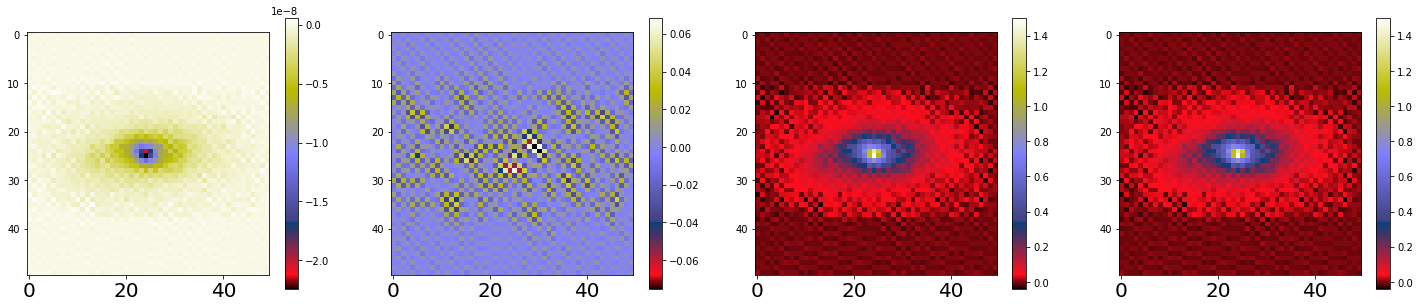

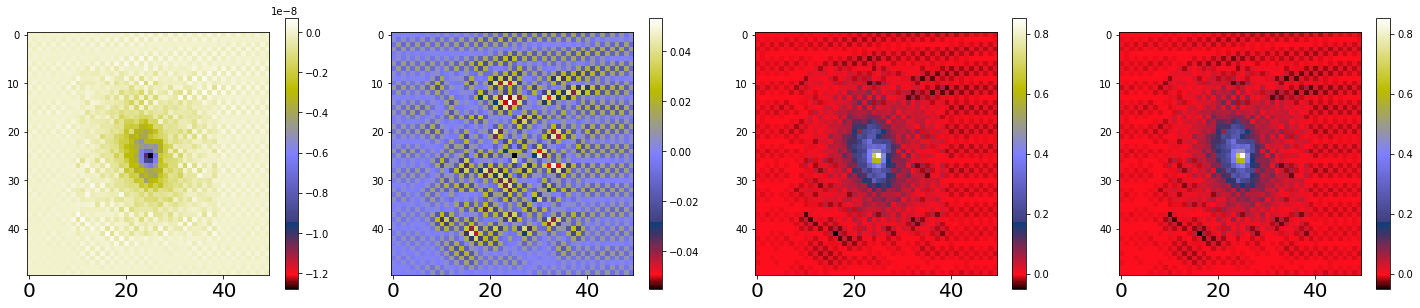

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}


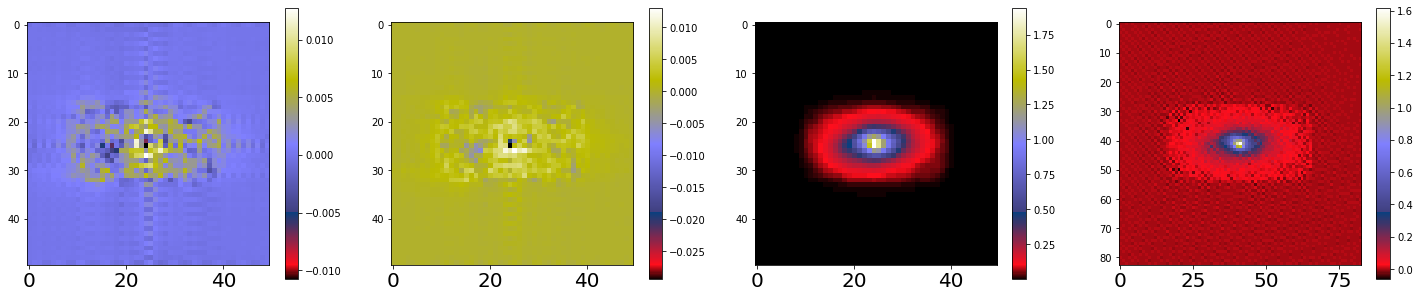

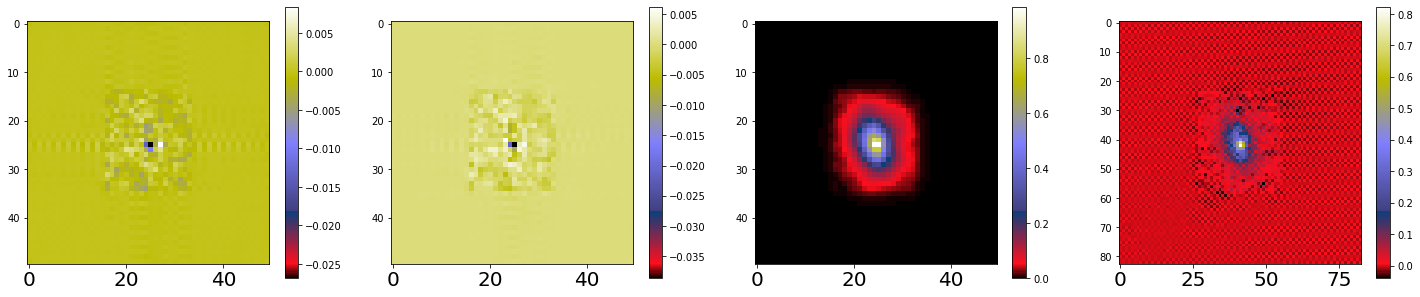

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}


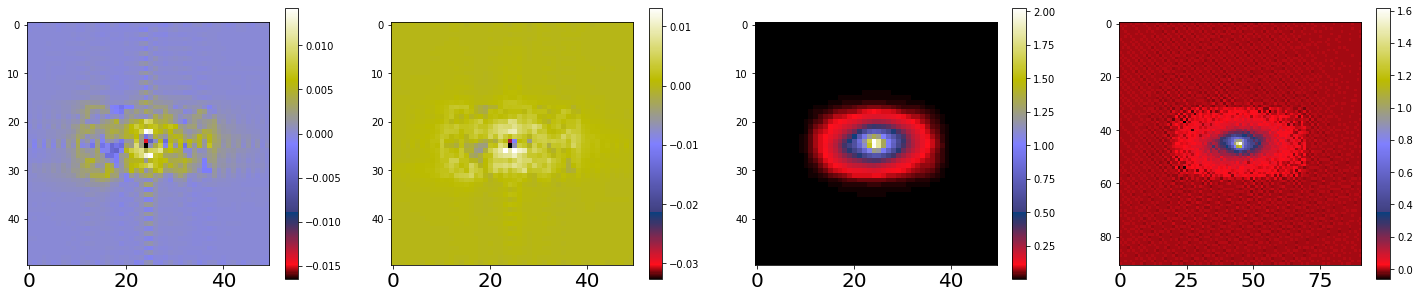

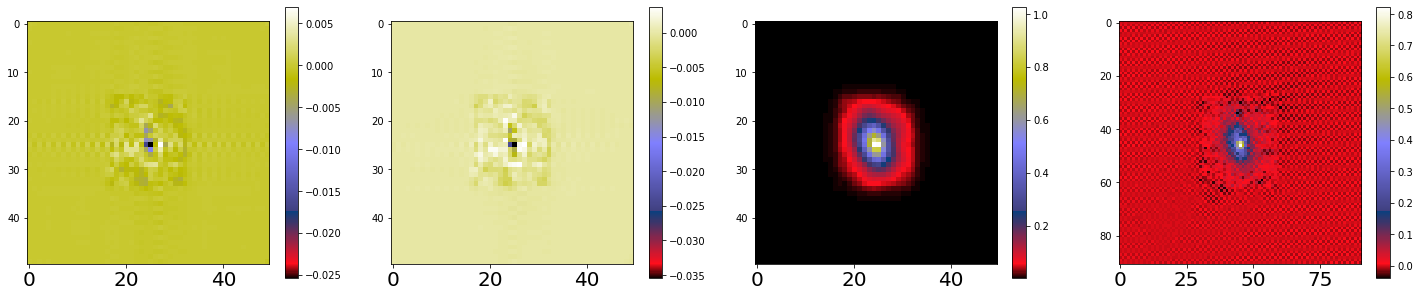

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}


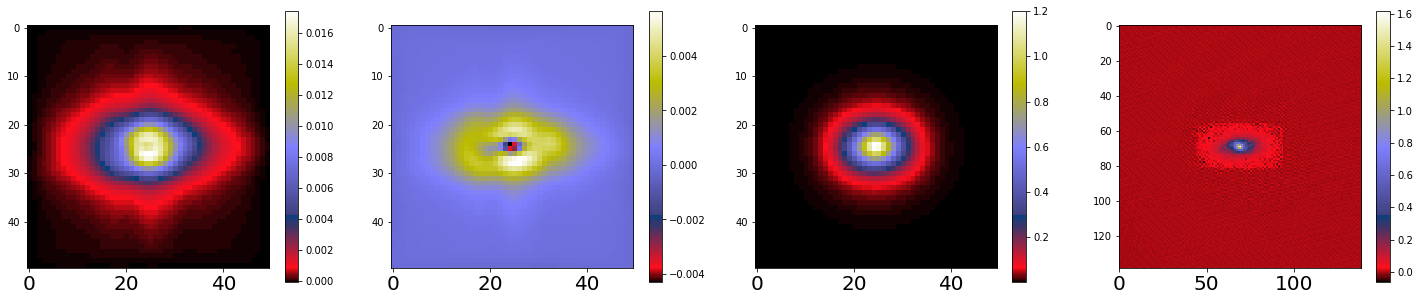

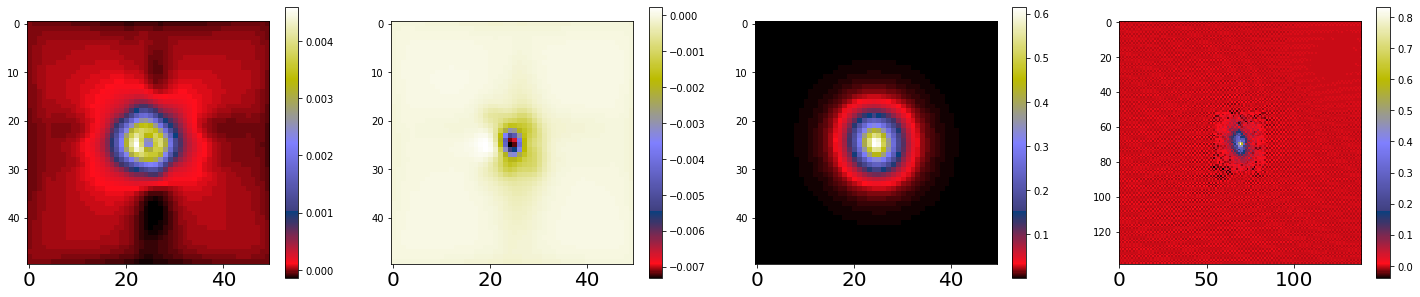

HR {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


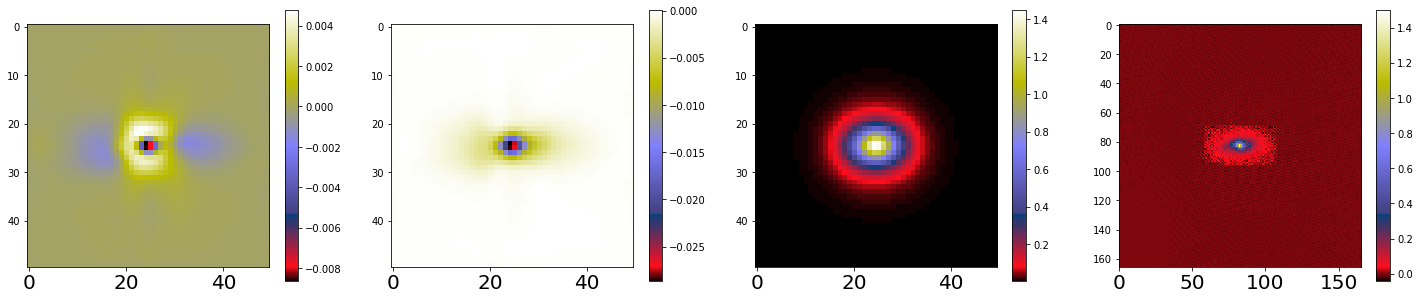

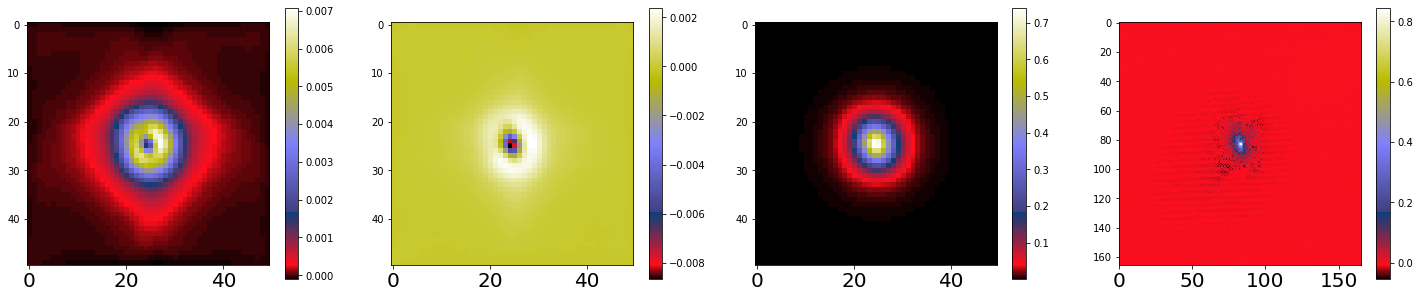

HR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
LR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}


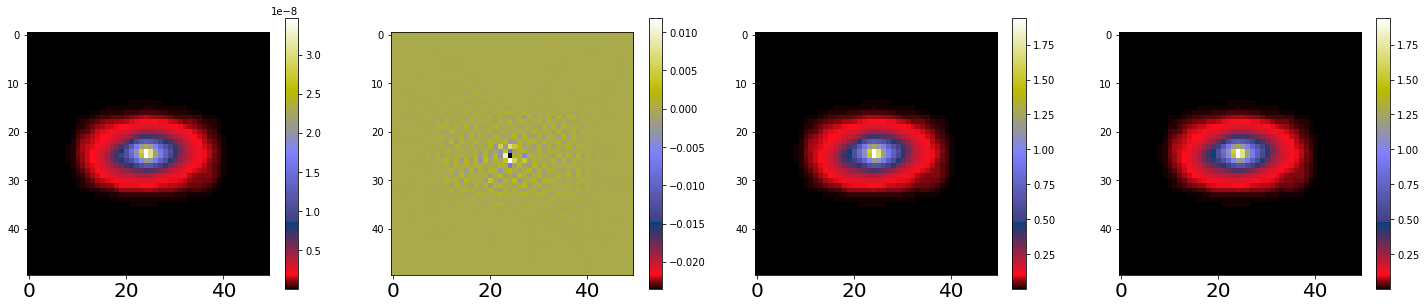

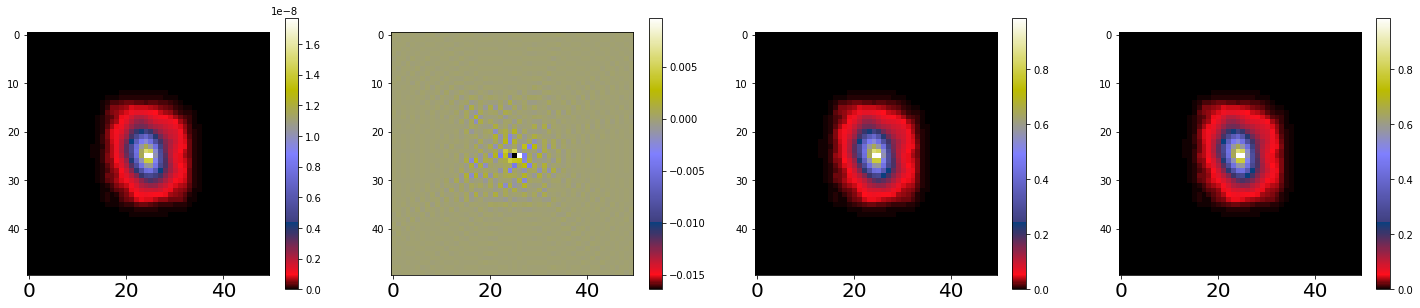

HR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
LR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}


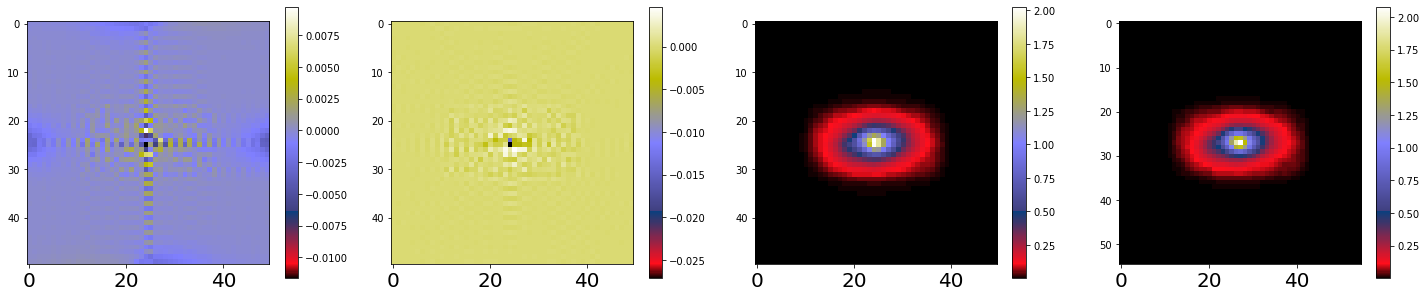

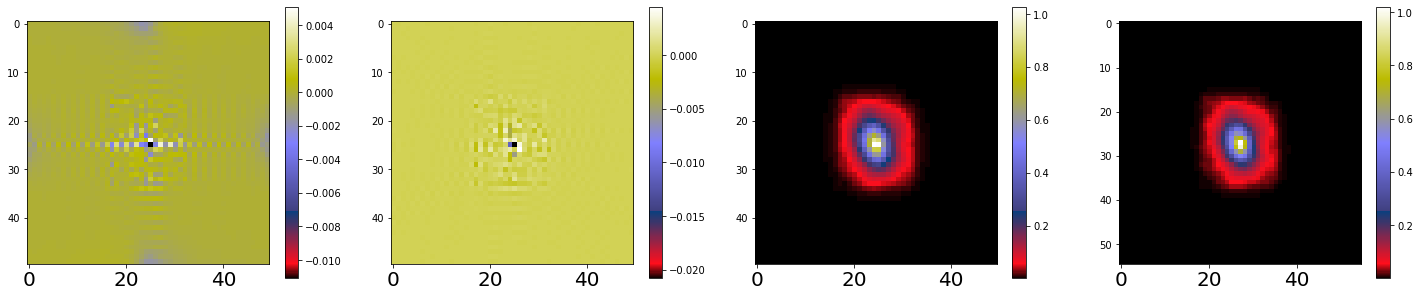

HR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
LR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}


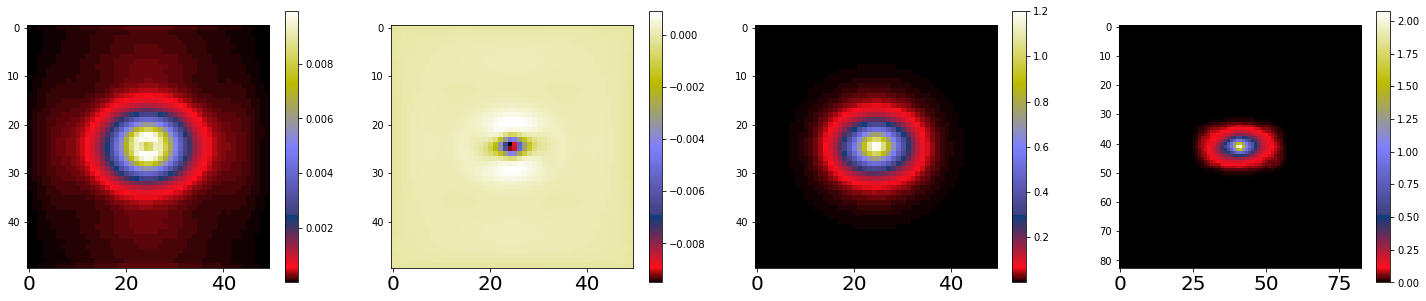

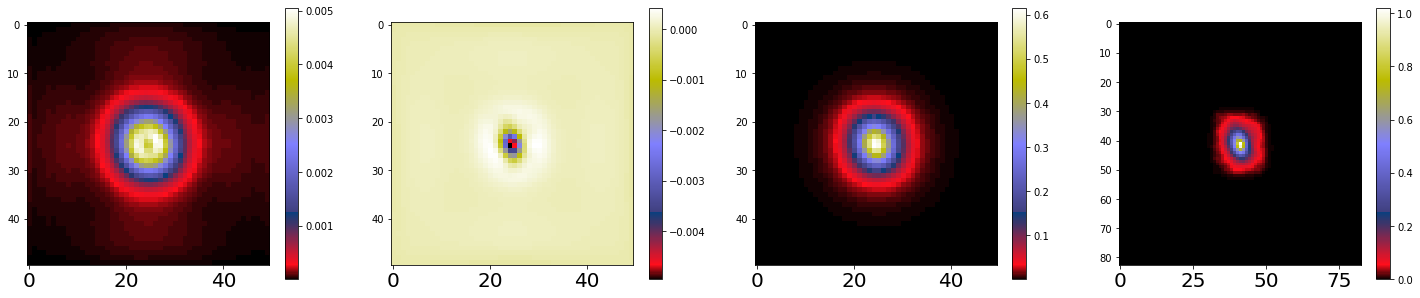

HR {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


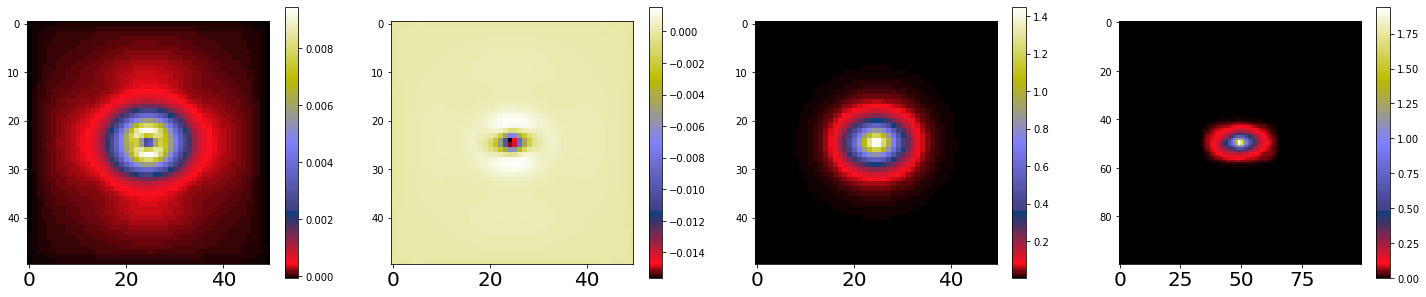

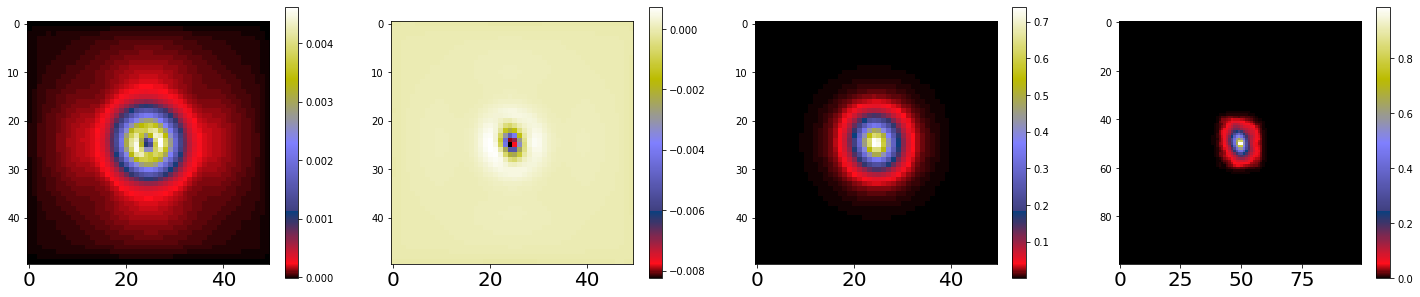

HR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
LR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}


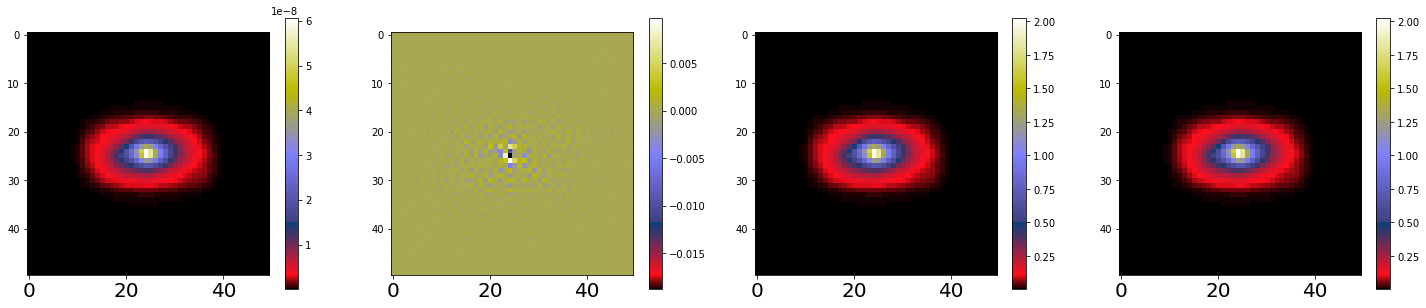

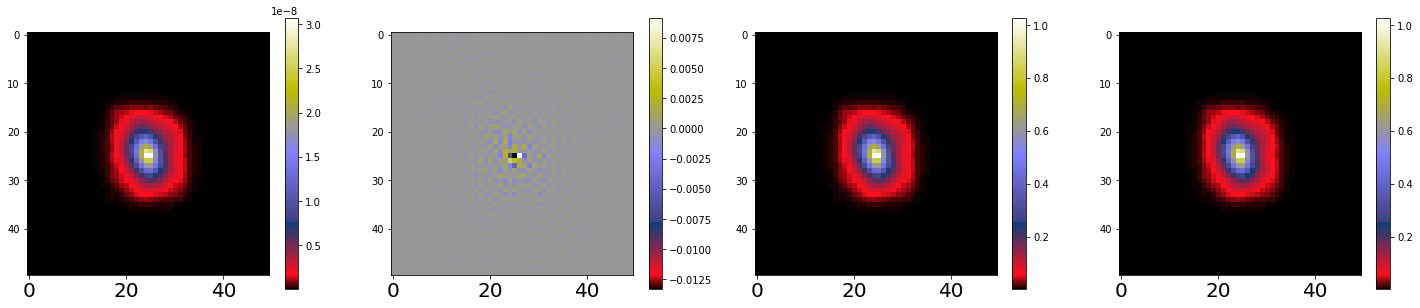

HR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
LR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}


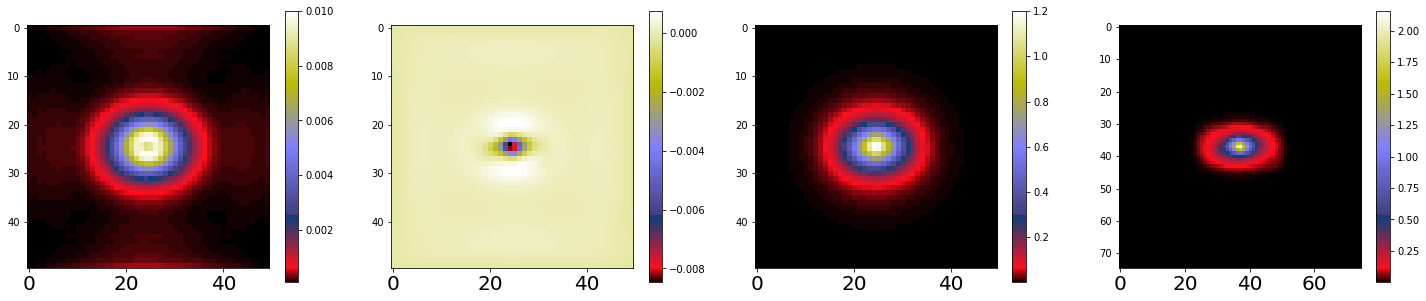

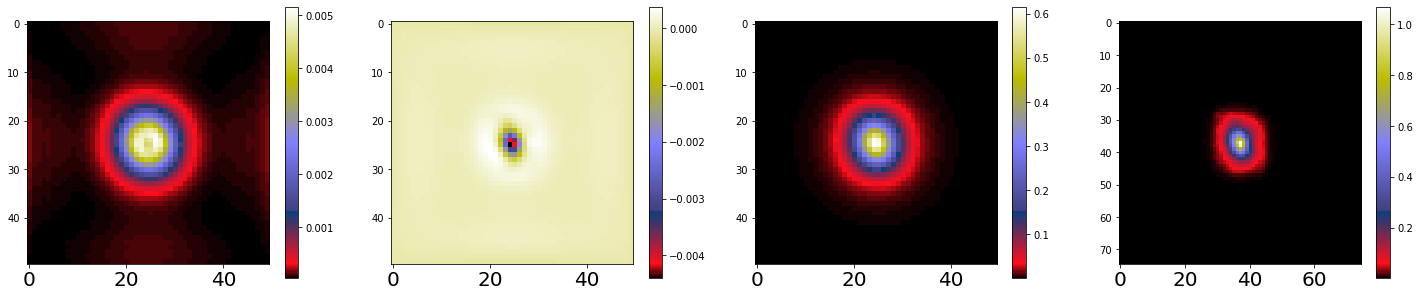

HR {'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


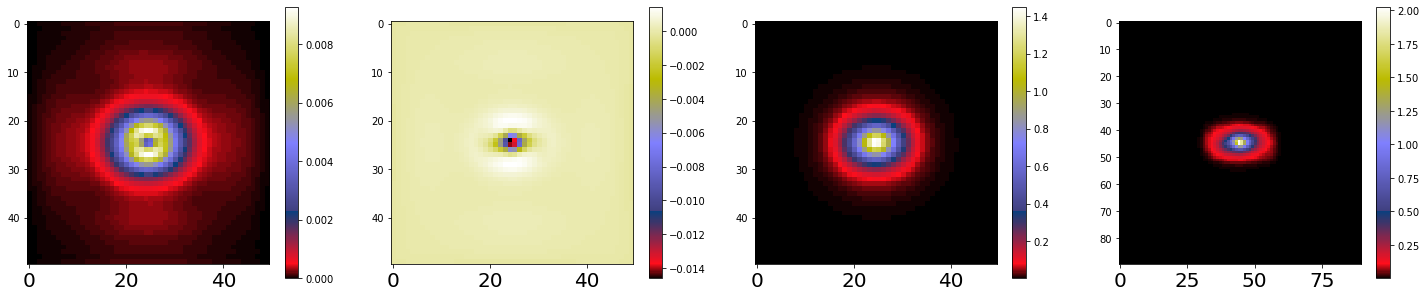

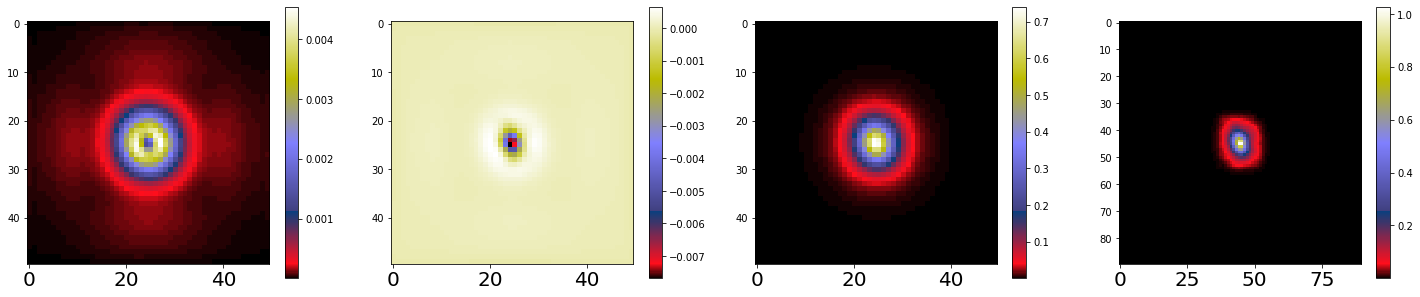

HR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
LR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}


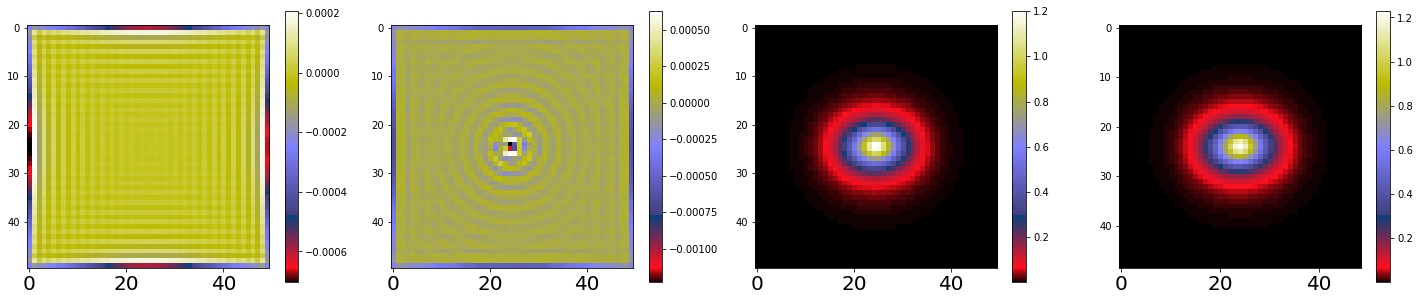

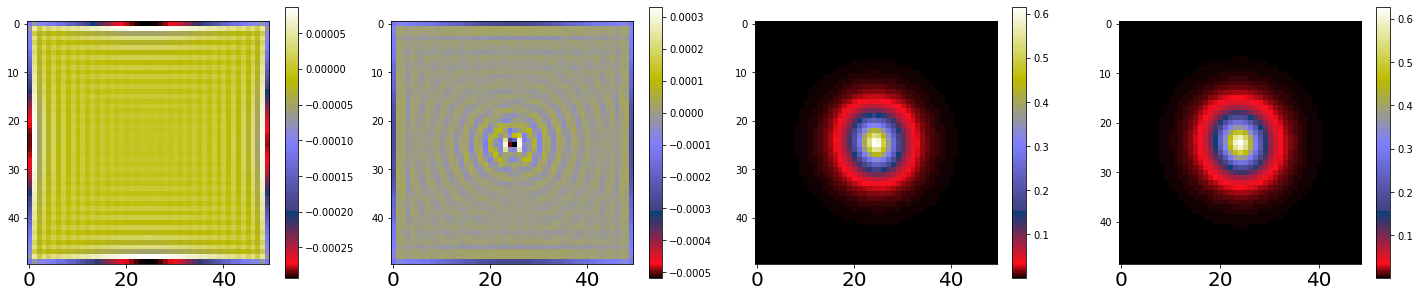

HR {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


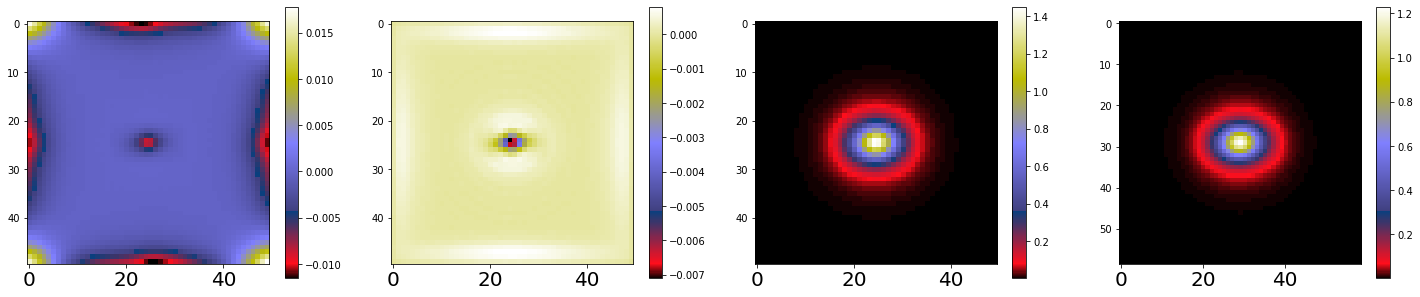

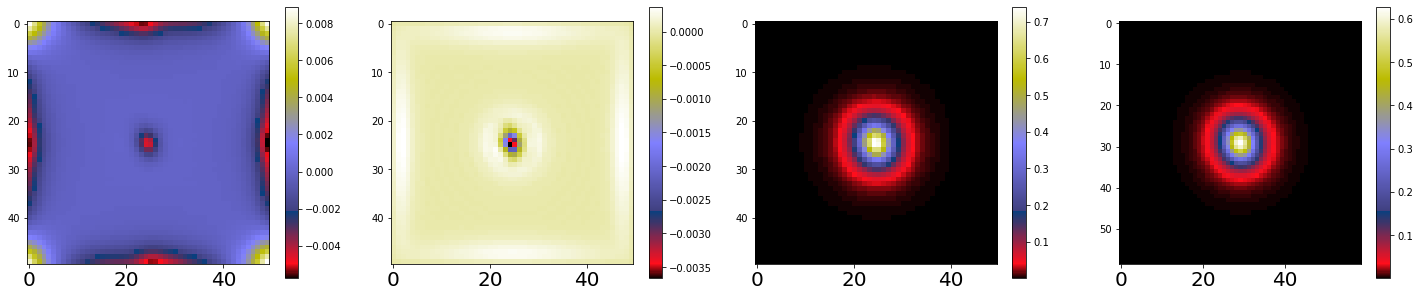

HR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
LR {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}


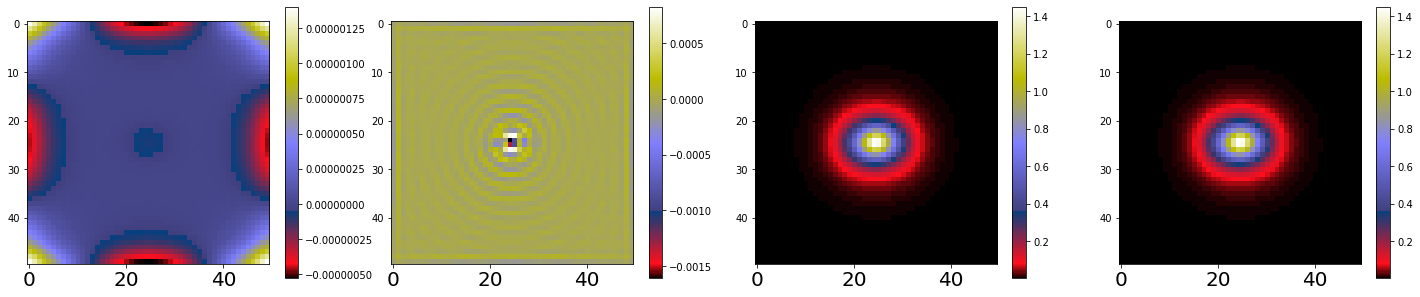

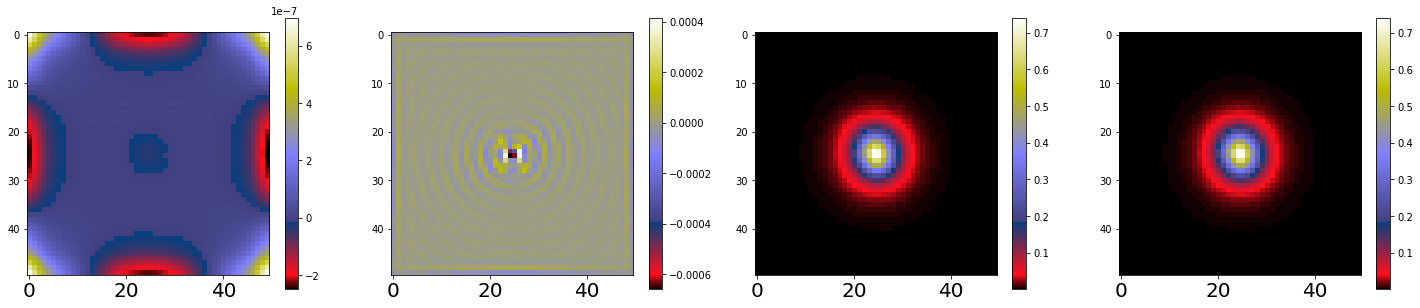

In [5]:
# Test reconstructions 
nlr = 50
surveys = [HST, EUCLID, WFIRST, HSC, LSST]


reconstructions = {'survey_lr': [], 'survey_hr': [], 'n_hr': [], 'true_flux': [], 'lr_flux': [], 
                   's_flux': [], 'g_flux': [], 's_sdr': [], 'g_sdr': []}

def SDR(X_true, X):
    return 10*np.log10(np.sum(X_true**2)**0.5/np.sum((X_true-X)**2)**0.5)


for gg, surveyhr in enumerate(surveys):
    for g, surveylr in enumerate(surveys[gg:]):
        print('HR', surveyhr)
        print('LR', surveylr)
        for i in range(len(cat)):
            nhr = int(nlr*surveylr['pixel']/surveyhr['pixel'])
        
            # Galsim setup:
            data_hr, data_lr, psf_hr, psf_lr, angle = mk_sim(int(i), surveyhr, surveylr, (nhr, nhr), (nlr, nlr))

            ## GSO from psf_hr for galsim
            psf_hr_galsim = galsim.InterpolatedImage(galsim.Image(psf_hr[0]), 
                                               scale = surveyhr['pixel'], use_true_center = False)
            ## deconvolution kernel for diff kernel
            deconv = galsim.Deconvolve(psf_hr_galsim)
            ## Interpolation of low resolution psf at high resolution
            psf_lr_hr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                               scale = surveylr['pixel'], use_true_center = False)
            ## Difference kernel from galsim
            diff_gal = galsim.Convolve(deconv, psf_lr_hr)
            diff = diff_gal.drawImage(nx=npsf,ny=npsf, scale=surveyhr['pixel']).array[None, :,:]
            
            # Make simulations
            data_hr, data_lr, psf_hr, psf_lr, angle = mk_sim(i, surveyhr, surveylr, (nhr, nhr), (nlr, nlr))

            # scarlet setup
            obs_lr = interp_scarlet(data_hr, data_lr, psf_hr, psf_lr)

        
            # Scarlet timing
            scar_rec = obs_lr.render(data_hr.array[None,:,:])
            # Galsim timing
            gal_rec = interp_galsim(data_hr, data_lr, diff_gal, angle, surveyhr['pixel'], surveylr['pixel'])
        
            if i%50 ==0:
                figure(figsize = (25,5))
                subplot(141)
                imshow((scar_rec[0]-data_lr.array))
                colorbar()
                subplot(142)
                imshow((gal_rec.array-data_lr.array))
                colorbar()
                subplot(143)
                imshow((data_lr.array))
                colorbar()
                subplot(144)
                imshow((data_hr.array))
                colorbar()
                show()
            
            reconstructions['survey_lr'].append(surveylr) 
            reconstructions['survey_hr'].append(surveyhr) 
            reconstructions['n_hr'].append(nhr) 
            reconstructions['true_flux'].append((data_hr.array).sum())
            reconstructions['lr_flux'].append((data_lr.array).sum())
            reconstructions['s_flux'].append((scar_rec).sum())
            reconstructions['g_flux'].append((gal_rec.array).sum())
            reconstructions['s_sdr'].append(SDR(data_lr.array,scar_rec))
            reconstructions['g_sdr'].append(SDR(data_lr.array,gal_rec.array))
import pickle   
bfile = open('Precision_npsf='+str(npsf)+'.pkl', 'wb')
pickle.dump(reconstructions, bfile)
bfile.close()

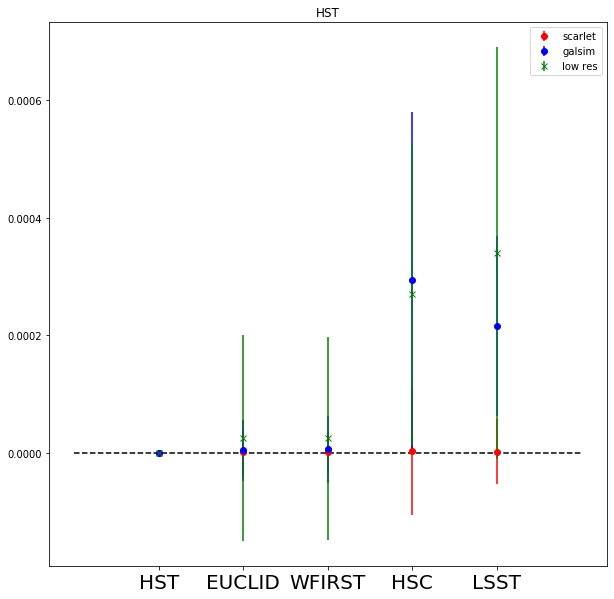

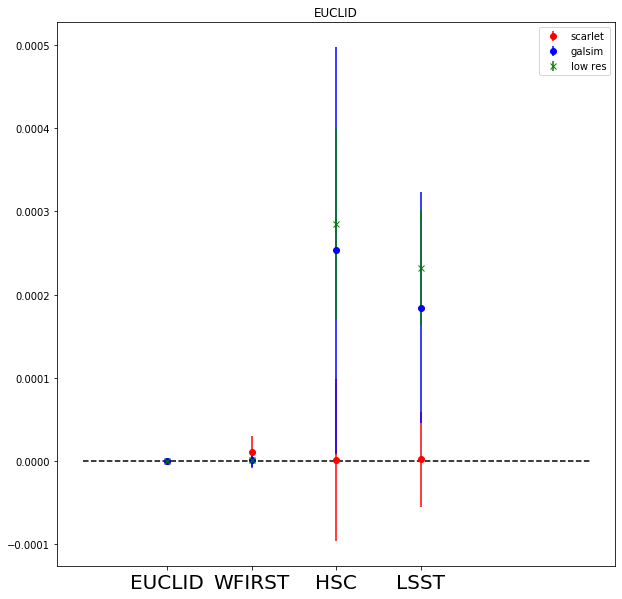

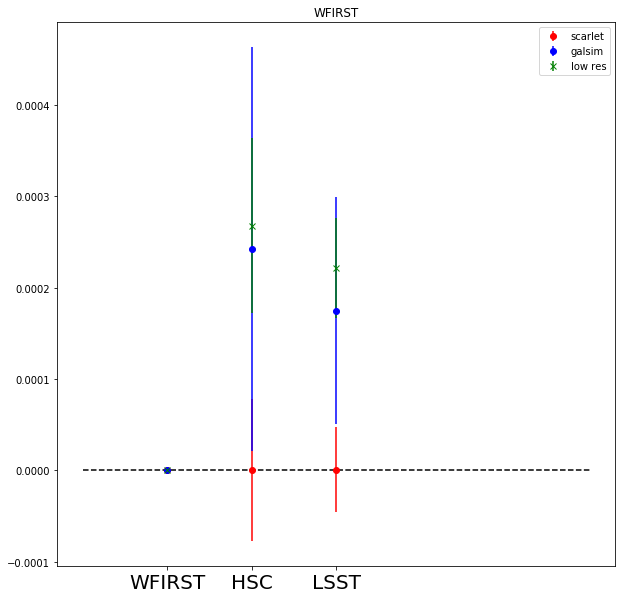

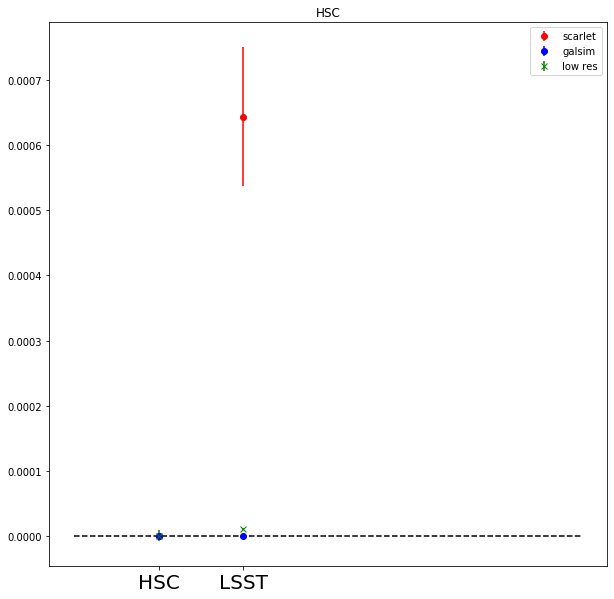

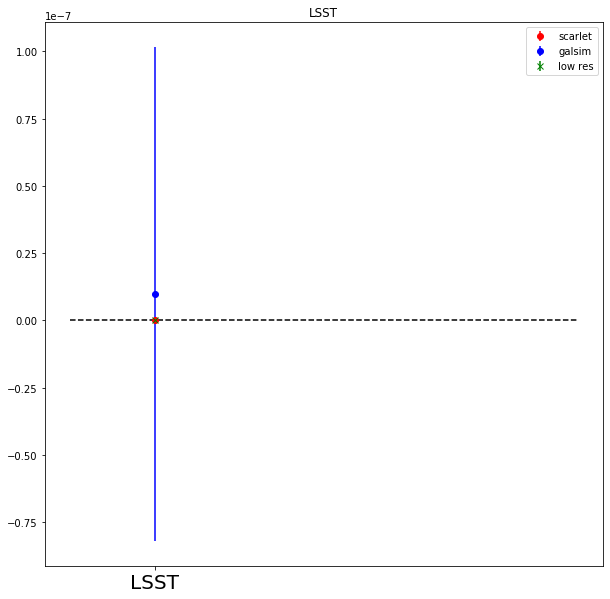

In [6]:

surv_lr = np.array(reconstructions['survey_lr'])
surv_hr = np.array(reconstructions['survey_hr'])
n_hrs = np.array(reconstructions['n_hr'])
truths = np.array(reconstructions['true_flux'])
truth_lr = np.array(reconstructions['lr_flux'])
s_fluxs = np.array(reconstructions['s_flux'])
g_fluxs = np.array(reconstructions['g_flux'])
s_sdr = np.array(reconstructions['s_sdr'])
g_sdr = np.array(reconstructions['g_sdr'])

scar_diff = (truths-s_fluxs)**2/truths**2
gal_diff = (truths-g_fluxs)**2/truths**2
lr_diff = (truths-truth_lr)**2/truths**2

def plot_error_for_survey(x,condition, label = [None, None, None]):
    errorbar(x, (np.median(scar_diff[condition])), fmt = 'or', label = label[0], yerr = np.std(scar_diff[condition]))
    errorbar(x, (np.median(gal_diff[condition])), fmt = 'ob', label = label[1], yerr = np.std(gal_diff[condition]))
    errorbar(x, (np.median(lr_diff[condition])), fmt = 'xg', label = label[2], yerr = np.std(lr_diff[condition]))
    pass

#figure(figsize = (40,10))

for e, hr in enumerate(surveys):
    figure(figsize = (10,10))
    for ee, lr in enumerate(surveys[e:]):
        if ee == 0:
            plot_error_for_survey(ee+1,(surv_hr == hr)*(surv_lr == lr), label = ['scarlet', 'galsim', 'low res'])
        else:
            
            plot_error_for_survey(ee+1,(surv_hr == hr)*(surv_lr == lr))
    names = [l['name'] for j,l in enumerate(surveys[e:])]
    plt.title(hr['name'])
    plt.xticks((np.arange(ee+1)+1), names)
    plot([0,6], [0,0], '--k')
    legend()
    show()

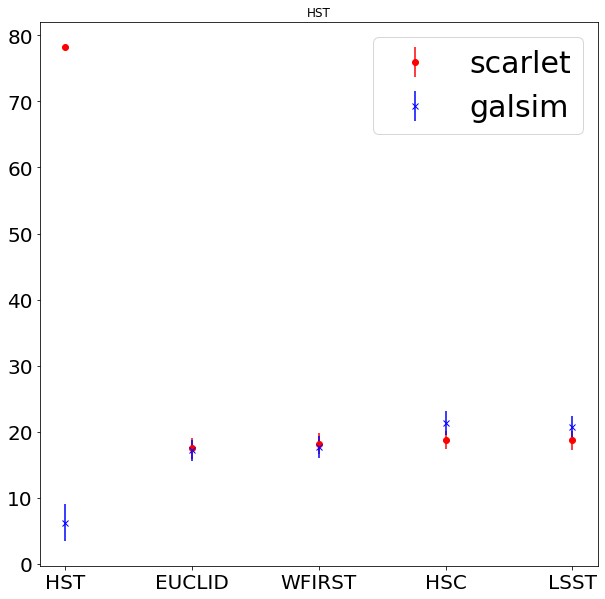

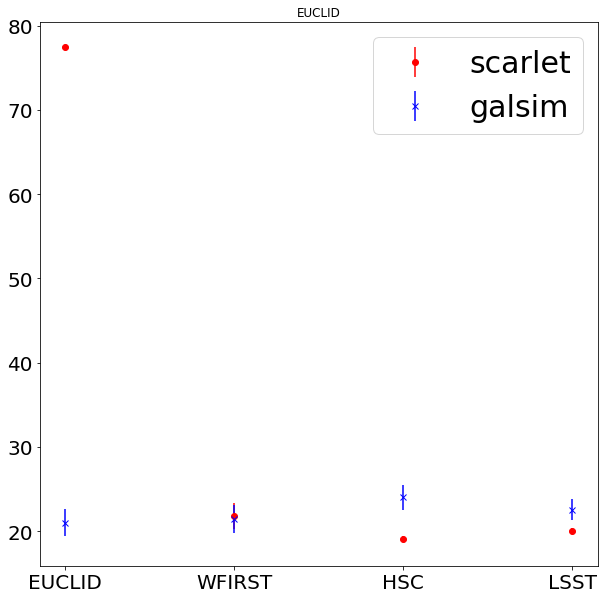

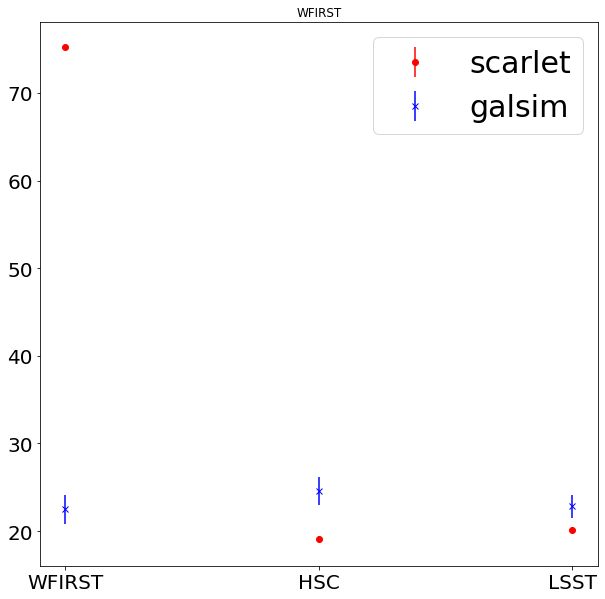

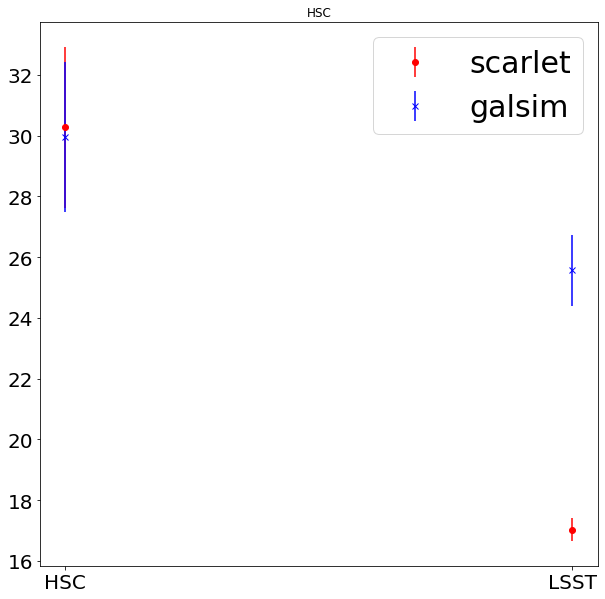

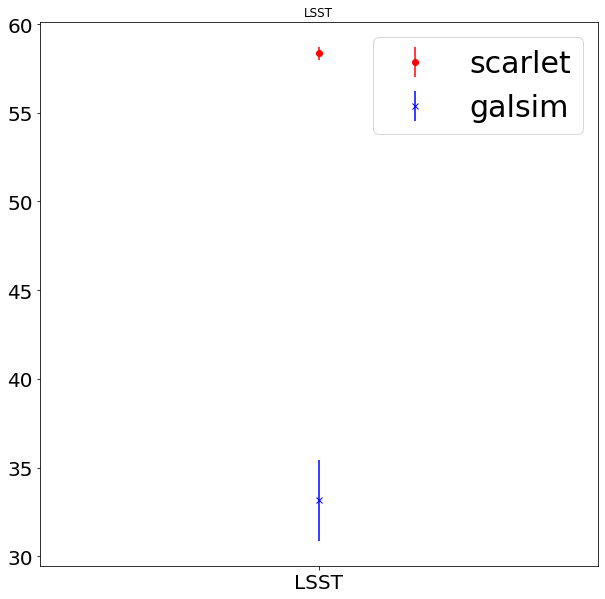

In [7]:
survey_lr = np.array(reconstructions['survey_lr'])
survey_hr = np.array(reconstructions['survey_hr'])
n_hrs = np.array(reconstructions['n_hr'])
s_sdr = np.array(reconstructions['s_sdr'])
g_sdr = np.array(reconstructions['g_sdr'])

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_sdr(x, condition, label = [None, None]):
    errorbar(x, np.median(s_sdr[condition]), fmt = 'or', label = label[0],
                 yerr = np.std(s_sdr[condition]))
    errorbar(x, np.median(g_sdr[condition]), fmt = 'xb', label = label[1],
                 yerr = np.std(g_sdr[condition]))
    pass

for e, hr in enumerate(surveys):
    figure(figsize = (10,10))
    plt.title(hr['name'])
    for ee, lr in enumerate(surveys[e:]):
        if ee == 0:
            plot_sdr(ee,(survey_hr == hr)*(survey_lr == lr), label = ['scarlet', 'galsim'])
        else:
            plot_sdr(ee,(survey_hr == hr)*(survey_lr == lr))
   
    names = [l['name'] for j,l in enumerate(surveys[e:])]
    plt.xticks((np.arange(ee+1)), names)
    legend(fontsize = 30)
    show()